# 일원분산분석 - 연습문제

## 공통 준비 작업

### 1. 패키지 가져오기:

In [25]:
from hossam import load_data
from pandas import melt, DataFrame
from matplotlib import pyplot as plt
from matplotlib import font_manager as fm
import seaborn as sb
from math import sqrt

# 가정 확인을 위한 라이브러리:
from scipy.stats import t, normaltest, bartlett, levene

# 분산분석을 위한 라이브러리:
from pingouin import anova, welch_anova

# 사후검정을 위한 라이브러리:
from pingouin import pairwise_tukey, pairwise_tests, pairwise_gameshowell

## 2. 그래프 초기화:

In [26]:
my_dpi = 200  # 이미지 선명도 (100~300)
font_path = r"\Users\itwill\OneDrive\문서\학원수업\NotoSansKR-Regular.ttf"  # 한글을 지원하는 폰트 파일의 경로
fm.fontManager.addfont(font_path)      # 폰트 글꼴을 시스템에 등록함
font_prop = fm.FontProperties(fname = font_path)    # 폰트 속성을 읽어옴
font_name = font_prop.get_name()    # 읽어온 속성에서 폰트의 이름만 추출

plt.rcParams['font.family'] = font_name # 그래프에 한글폰트 적용
plt.rcParams['font.size'] = 6          # 기본 폰트 크기
plt.rcParams['axes.unicode_minus'] = False  
    # 그래프에 마이너스 깨짐 방지 (한글 환경에선 필수)

## 문제 1:
`tree_weight` 데이터셋은 소나무 품종별 무게를 조사한 데이터이다. 소나무 품종별로 평균 무게에 차이가 있는지 분석하라.

### 1. 데이터 가져오기:

In [27]:
origin = load_data('tree_weight')

print("\n===== 데이터 크기 확인 =====")
print(f"데이터셋 크기: {origin.shape}")
print(f"열 갯수: {origin.shape[1]}")
print(f"행 갯수: {origin.shape[0]}")

print("\n===== 타입 확인 =====")
print(origin.info())

origin.head()

[data] https://data.hossam.kr/data/lab10_/tree_weight.xlsx
[desc] 소나무 품종별 무게를 조사한 데이터 (출처: 방송통신대학교 통계학개론)
[!] Cannot read metadata

===== 데이터 크기 확인 =====
데이터셋 크기: (30, 2)
열 갯수: 2
행 갯수: 30

===== 타입 확인 =====
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30 entries, 0 to 29
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   weight  30 non-null     float64
 1   group   30 non-null     object 
dtypes: float64(1), object(1)
memory usage: 612.0+ bytes
None


,weight,group
0,4.17,A
1,5.58,A
2,5.18,A
3,6.11,A
4,4.50,A


### 2. 데이터 분포 확인하기:

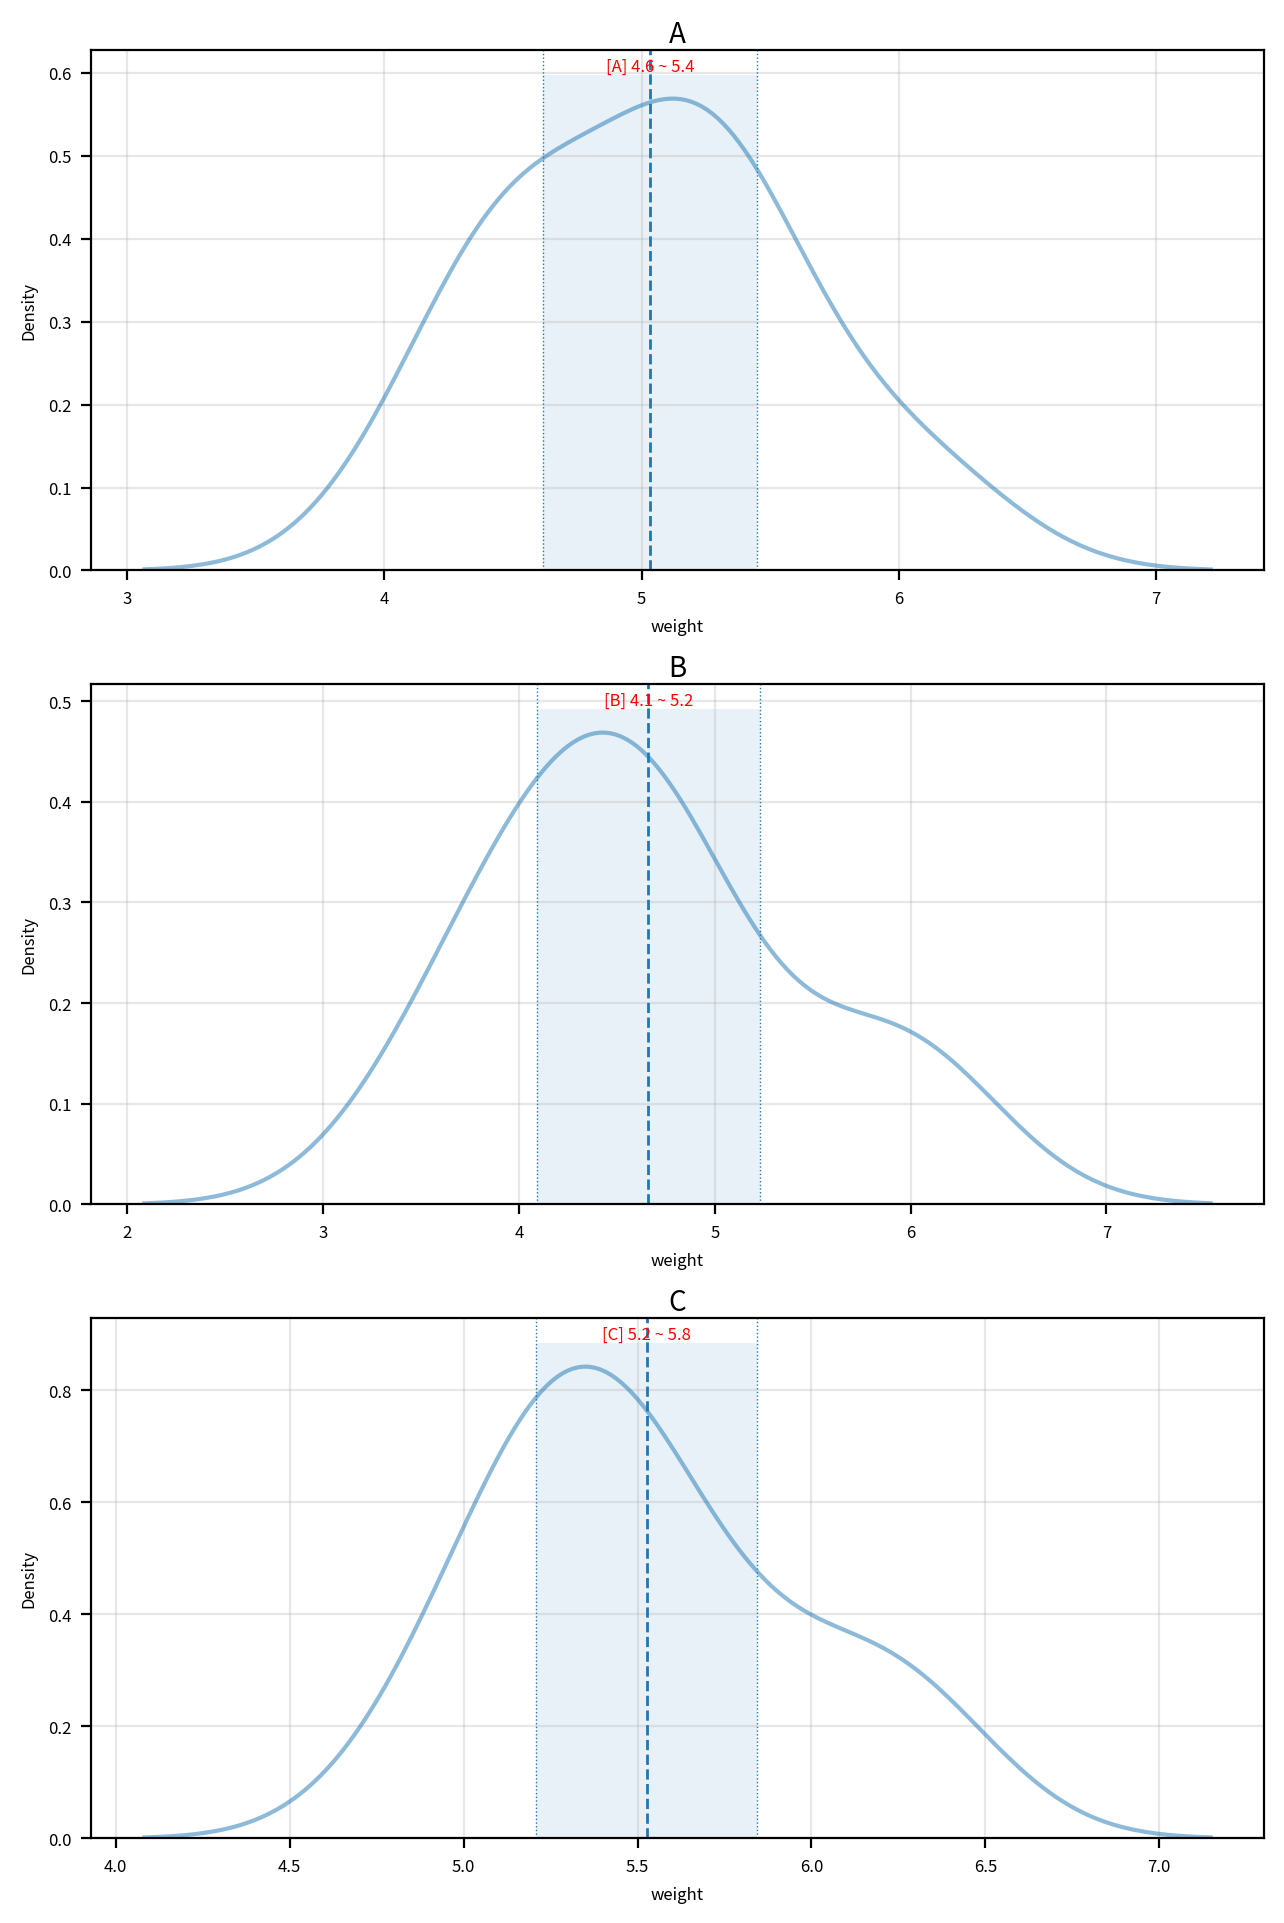

In [28]:
# 확인할 데이터 필드 (수치형):
field = 'weight'

# 집단 구분용 필드 (범주형, hue):
hue_field = 'group'

# 요일 종류: 
hue_values = origin[hue_field].unique()
hue_count = len(hue_values)

# 1) 그래프 초기화 (초기설정, 캔버스(fig)랑 도화지(ax) 준비하기)
width_px = 1280             # 그래프 가로 크기
height_px = 640 * 3         # 그래프 세로 크기
rows = 3                    # 그래프 행 수
cols = 1                    # 그래프 열 수
figsize = (width_px / my_dpi, height_px / my_dpi)
fig, ax = plt.subplots(rows, cols, figsize = figsize, dpi = my_dpi)

for i, v in enumerate(hue_values):
    temp = origin[origin[hue_field] == v]
    #display(temp)

    # 2) KDE plot 그리기:
    sb.kdeplot(data=temp, x=field, fill=False, ax = ax[i], alpha=0.5)
    ax[i].grid(True, alpha=0.3)
    ax[i].set_title(v, fontsize=10, pad=3)

    # 신뢰구간용 기본변수:
    max = temp[field].max()                        # 최대값
    dof = len(temp[field]) - 1                     # 자유도
    clevel = 0.95                                  # 신뢰수준
    sp_mean = temp[field].mean()                   # 표본평균
    sp_std = temp[field].std(ddof=1) # default: ddof=1   # 표본표준편차
    sp_std_error = sp_std / sqrt(len(temp[field])) # 표본표준오차

    cmin, cmax = t.interval(clevel, dof, loc = sp_mean, scale = sp_std_error)

    ax[i].axvline(cmin, linestyle=":", linewidth=0.5) # cmin 경계선
    ax[i].axvline(cmax, linestyle=":", linewidth=0.5) # cmax 경계선

    # 신뢰구간 y값, 평균표시:
    ymin, ymax = ax[i].get_ylim()
    ax[i].fill_between([cmin, cmax], 0, ymax, alpha=0.1)
    ax[i].axvline(sp_mean, linestyle='--', linewidth=1)

    # 텍스트 그리기 (statAnnotator 기능):
    ax[i].text(x = cmin + (cmax-cmin)/2,
            y=ymax,
            s="[%s] %0.1f ~ %0.1f" % (v, cmin, cmax),
            horizontalalignment = "center",
            verticalalignment = "bottom",
            fontdict = {"size": 6, "color": "red"})

# 4) 출력
plt.tight_layout()           # 여백 제거
plt.show()                   # 그래프 화면 출력
plt.close()                  # 그래프 작업 종료

### 3. 정규성, 등분산성 가설 검정하기:

In [29]:
# hue 별 그룹 생성:
groups = [(name, grp['weight']) for name, grp in origin.groupby('group')]
# ↑: pivot table (리스트, 2차월 배열 같은) 만든거임 
    # grping 된 data들
    # ex) [(금, [a, b, c, ..]), (토, [m,n,o,..]), (일, [..])]

report = []
normal_dist = True

for name, series in groups:
    stat, p = normaltest(series)
    ok = p > 0.05
    report.append({
        "fields": name,
        "statistic": stat,
        "p-value": p,
        "result": ok
    })
    normal_dist = normal_dist and ok

# 등분산성 검정법 선택:
    # 정규성 충족할 때 등분산성 검정방법:
if normal_dist:
    test_name = "Bartlett"
    stat, p = bartlett(*[s.values for _, s in groups]) # 모든 컬럼의 데이터 한번에
# 정규성 충족 못할 때 등분산성 검정법:
else:
    test_name = "Levene's"
    stat, p = levene(*[s.values for _, s in groups], 
                        center='median')
    # : 정규성 충족 못할 땐 '기본값인 평균'으로 계산하면 안됨

equal_var = p > 0.05

report.append({
    "fields": test_name,
    "statistic": stat,
    "p-value": p,
    "result": equal_var
})

report_df = DataFrame(report).set_index('fields')
report_df

,statistic,p-value,result
fields,,,
A,0.233496,0.889810,True
B,0.967741,0.616393,True
C,1.013177,0.602548,True
Bartlett,2.878574,0.237097,True


### 4. 집단 간 평균 비교하기:

In [30]:
# 분석할 데이터만 추출:
anova_df = origin[['weight', 'group']].copy()
#anova_df   #display(anova_df)

# pingouin 패키지 사용:
if equal_var: # : 만약 등분산성 충족하면
    pg_anova = anova(data=anova_df, dv='weight', between='group')
else: # : 만약 등분산성 충족 못하면
    pg_anova = welch_anova(data=anova_df, dv='weight', between='group')
#pg_anova   #display(pg_anova)

# 결과 확인:
f_val = pg_anova['F'].iloc[0]
p_val = pg_anova['p-unc'].iloc[0]
"statistic: {0:.3f}, p-value: {1:.3f}, {2}가설 채택".format(f_val, p_val, "대립" if p_val<=0.05 else "귀무")
#display("statistic: {0:.3f}, p-value: {1:.3f}, {2}가설 채택".format(f_val, p_val, "대립" if p_val<=0.05 else "귀무"))


'statistic: 4.846, p-value: 0.016, 대립가설 채택'

In [31]:
#결론: A, B, C 그룹 간 평균무게 끼리는 유의미한 차이 있다
# 얼마나? -> 사후검정 ㄱㄱ
if equal_var:
    print("=== Tukey HSD ===")
    hoc_df = pairwise_tukey(data=anova_df, dv='weight', between='group')
else:
    print("=== Games-Howell ===")
    hoc_df = pairwise_gameshowell(data=anova_df, dv='weight', between='group')

hoc_df

=== Tukey HSD ===


,A,B,mean(A),mean(B),diff,se,T,p-tukey,hedges
0,A,B,5.032,4.661,0.371,0.278782,1.330791,0.390871,0.510237
1,A,C,5.032,5.526,-0.494,0.278782,-1.771996,0.197996,-0.914038
2,B,C,4.661,5.526,-0.865,0.278782,-3.102787,0.012006,-1.289277


### **인사이트:**
===========<강사님이 쓴거:>==========

**1. 집단 별 평균(weight):**

| 집단 | 평균 |
| ---- | --- |
| A | 5.032 |
| B | 4.661 |
| C | 5.526 |

-> C가 가장 크고 B가 가장 작음.

**2. 집단 간 비교(사후검정)결과 해석(표):**

| 비교쌍 | 평균 차 **(diff)** | **p-value (Tukey)** | **통계적 유의성** | **효과크기 (hedges g)** | 해석 |
| ---- | ---- | ---- | ---- | ---- | ---- |
| **A vs B** | 0.371 | 0.3909 | 유의 X | 0.510 (중간) | A가 더 무겁긴 하나 통계적으로 유의미하진 않음 |
| **A vs C** | -0.494 | 0.1980 | 유의 X | -0.914 (비교적 큰 효과) | C가 더 무겁긴 하나 유의성 부족 |
| **B vs C** | -0.865 | **0.0120** | **유의함!** | -1.289 (매우 큰 효과) | **C가 B보다 유의미하게 더 무거움** |

**3. 결론 요약:**
- C 집단 소나무는 B 집단보다 통계적으로 유의미하게 더 무겁다.
- A 집단은 B, C 어느 쪽 과도 유의미한 차이를 보이지 않았다.

=========<아래는 내가 쓴거:>=========
> 1. 모든 소나무 그룹들 각각은 그룹 별 평균 무게가 정규성과 등분산성을 만족하였고
>   - C(5.526) > A(5.032) > B(4.661) 순으로 평균 무게가 컸다. 
>
> 2. 그러나 소나무 품종 간 관계에 있어서 그룹간 평균무게의 차이의 유의미함에 에서는:
>   - A-B간, A-C간에는 p-turkey > 0.05로 나왔고, 이는 소나무 품종 A는 어느 품종과도 평균 무게가 통계적으로 유의미한 차이를 보이지 않음으로 해석할 수 있다.
>       - 만일 A-B, A-C 품종 간에 평균무게의 차이가 존재 하더라도, 이는 통계적 유의미함을 내포하지 않고, 표본 내 자연스러운 변동으로 인한 결과로 볼 수 있다. 
>   - 이와 반대로, B-C간에는 p-turkey < 0.05로 나타나, 소나무 품종 B와 C간 평균무게의 차이는 유의미한 것으로 나타났다.
>  - 즉, C가 B보다 0.865만큼 유의미하게 더 무거움

## 문제 2:
`reading` 데이터셋은 유아들을 대상으로 세 가지 읽는 방법을 비교, 실험하여 얻은 독서평가 점수 데이터이다.

세 방법에 통계적으로 유의한 차이가 있는지 검정하라.

### 1. 데이터 가져오기:

In [32]:
origin = load_data('reading')

print("\n===== 데이터 크기 확인 =====")
print(f"데이터셋 크기: {origin.shape}")
print(f"열 갯수: {origin.shape[1]}")
print(f"행 갯수: {origin.shape[0]}")

print("\n===== 타입 확인 =====")
print(origin.info())

origin.head()

[data] https://data.hossam.kr/data/lab10_/reading.xlsx
[desc] 유아들을 대상으로 세 가지 읽는 방법을 비교,실험하여 얻은 독서평가 점수 데이터 (출처: 방송통신대학교 통계학개론)
[!] Cannot read metadata

===== 데이터 크기 확인 =====
데이터셋 크기: (90, 2)
열 갯수: 2
행 갯수: 90

===== 타입 확인 =====
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90 entries, 0 to 89
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   독서방법    90 non-null     object 
 1   점수      90 non-null     float64
dtypes: float64(1), object(1)
memory usage: 1.5+ KB
None


,독서방법,점수
0,B,7.7
1,B,1.5
2,B,4.3
3,B,5.4
4,B,4.3


### 2. 데이터 분포 확인하기:

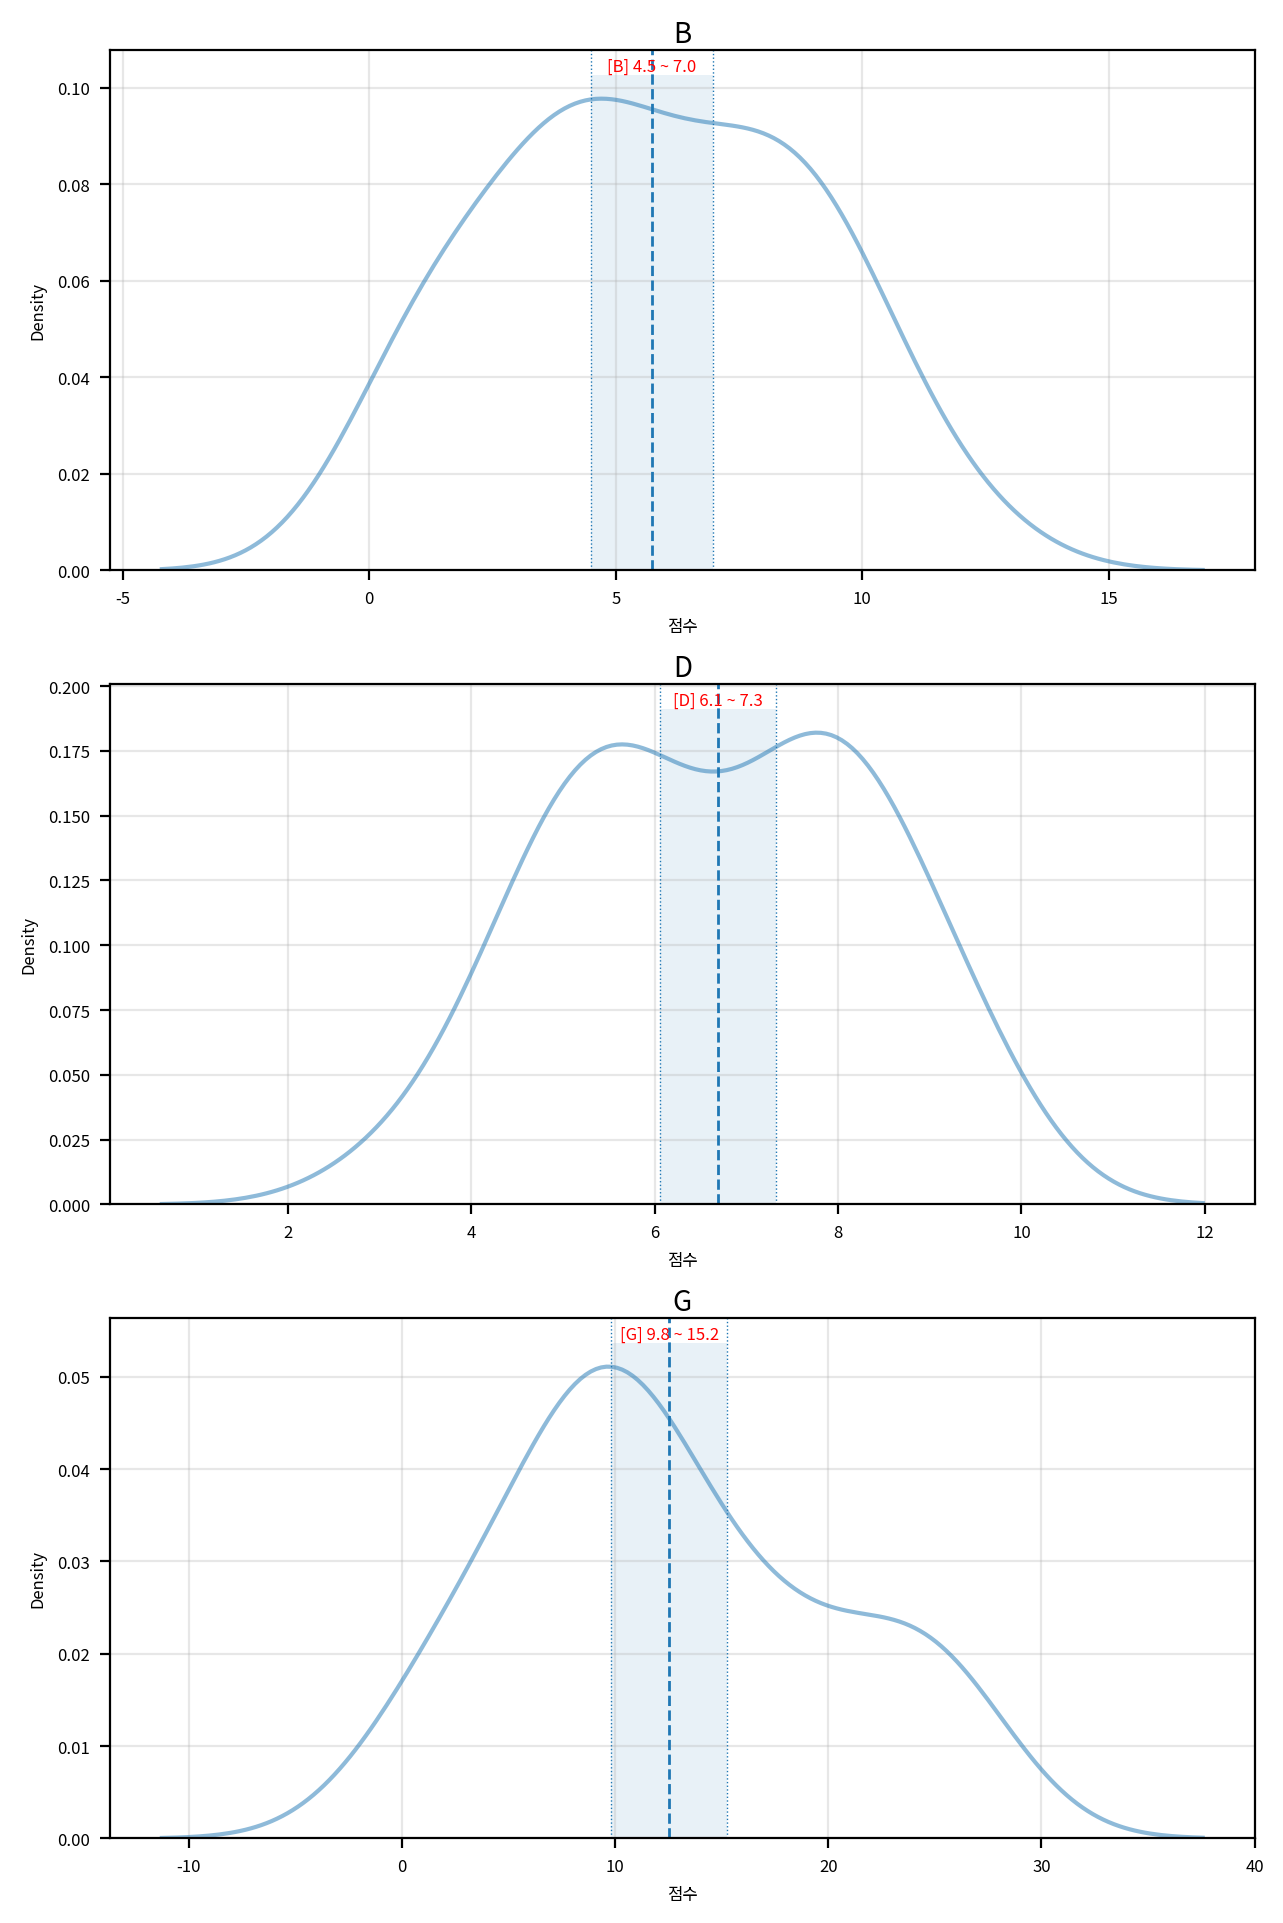

In [33]:
#origin['독서방법'].unique() -> 3종류(B, D, G)
# 확인할 데이터 필드 (수치형):
field = '점수'

# 집단 구분용 필드 (범주형, hue):
hue_field = '독서방법'

# 요일 종류: 
hue_values = origin[hue_field].unique()
hue_count = len(hue_values)

# 1) 그래프 초기화 (초기설정, 캔버스(fig)랑 도화지(ax) 준비하기)
width_px = 1280             # 그래프 가로 크기
height_px = 640 * 3         # 그래프 세로 크기
rows = 3                    # 그래프 행 수
cols = 1                    # 그래프 열 수
figsize = (width_px / my_dpi, height_px / my_dpi)
fig, ax = plt.subplots(rows, cols, figsize = figsize, dpi = my_dpi)

for i, v in enumerate(hue_values):
    temp = origin[origin[hue_field] == v]
    #display(temp)

    # 2) KDE plot 그리기:
    sb.kdeplot(data=temp, x=field, fill=False, ax = ax[i], alpha=0.5)
    ax[i].grid(True, alpha=0.3)
    ax[i].set_title(v, fontsize=10, pad=3)

    # 신뢰구간용 기본변수:
    max = temp[field].max()                        # 최대값
    dof = len(temp[field]) - 1                     # 자유도
    clevel = 0.95                                  # 신뢰수준
    sp_mean = temp[field].mean()                   # 표본평균
    sp_std = temp[field].std(ddof=1) # default: ddof=1   # 표본표준편차
    sp_std_error = sp_std / sqrt(len(temp[field])) # 표본표준오차

    cmin, cmax = t.interval(clevel, dof, loc = sp_mean, scale = sp_std_error)

    ax[i].axvline(cmin, linestyle=":", linewidth=0.5) # cmin 경계선
    ax[i].axvline(cmax, linestyle=":", linewidth=0.5) # cmax 경계선

    # 신뢰구간 y값, 평균표시:
    ymin, ymax = ax[i].get_ylim()
    ax[i].fill_between([cmin, cmax], 0, ymax, alpha=0.1)
    ax[i].axvline(sp_mean, linestyle='--', linewidth=1)

    # 텍스트 그리기 (statAnnotator 기능):
    ax[i].text(x = cmin + (cmax-cmin)/2,
            y=ymax,
            s="[%s] %0.1f ~ %0.1f" % (v, cmin, cmax),
            horizontalalignment = "center",
            verticalalignment = "bottom",
            fontdict = {"size": 6, "color": "red"})

# 4) 출력
plt.tight_layout()           # 여백 제거
plt.show()                   # 그래프 화면 출력
plt.close()                  # 그래프 작업 종료

### 3. 정규성, 등분산성 가설 검정하기:

In [34]:
# hue 별 그룹 생성:
groups = [(name, grp['점수']) for name, grp in origin.groupby('독서방법')]
# ↑: pivot table (리스트, 2차월 배열 같은) 만든거임 
    # grping 된 data들
    # ex) [(금, [a, b, c, ..]), (토, [m,n,o,..]), (일, [..])]

report = []
normal_dist = True

for name, series in groups:
    stat, p = normaltest(series)
    ok = p > 0.05
    report.append({
        "fields": name,
        "statistic": stat,
        "p-value": p,
        "result": ok
    })
    normal_dist = normal_dist and ok

# 등분산성 검정법 선택:
    # 정규성 충족할 때 등분산성 검정방법:
if normal_dist:
    test_name = "Bartlett"
    stat, p = bartlett(*[s.values for _, s in groups]) # 모든 컬럼의 데이터 한번에
# 정규성 충족 못할 때 등분산성 검정법:
else:
    test_name = "Levene's"
    stat, p = levene(*[s.values for _, s in groups], 
                        center='median')
    # : 정규성 충족 못할 땐 '기본값인 평균'으로 계산하면 안됨

equal_var = p > 0.05

report.append({
    "fields": test_name,
    "statistic": stat,
    "p-value": p,
    "result": equal_var
})

report_df = DataFrame(report).set_index('fields')
report_df

,statistic,p-value,result
fields,,,
B,2.210100,3.311943e-01,True
D,2.396634,3.017015e-01,True
G,2.216900,3.300701e-01,True
Bartlett,58.099241,2.420528e-13,False


### 4. 집단 간 평균 비교하기:

In [35]:
# 분석할 데이터만 추출:
anova_df = origin[['점수', '독서방법']].copy()
#anova_df

# pingouin 패키지 사용:
if equal_var: # : 만약 등분산성 충족하면
    pg_anova = anova(data=anova_df, dv='점수', between='독서방법')
else: # : 만약 등분산성 충족 못하면
    pg_anova = welch_anova(data=anova_df, dv='점수', between='독서방법')
display(pg_anova)

# 결과 확인:
f_val = pg_anova['F'].iloc[0]
p_val = pg_anova['p-unc'].iloc[0]
"statistic: {0:.3f}, p-value: {1:.3f}, {2}가설 채택".format(f_val, p_val, "대립" if p_val<=0.05 else "귀무")

,Source,ddof1,ddof2,F,p-unc,np2
0,독서방법,2,48.204128,10.787455,0.000134,0.283461


'statistic: 10.787, p-value: 0.000, 대립가설 채택'

In [36]:
#결론: hue 그룹 간 평균값 끼리는 유의미한 차이 있다
# 얼마나? -> 사후검정 ㄱㄱ
if equal_var:
    print("=== Tukey HSD ===")
    hoc_df = pairwise_tukey(data=anova_df, dv='점수', between='독서방법')
else:
    print("=== Games-Howell ===")
    hoc_df = pairwise_gameshowell(data=anova_df, dv='점수', between='독서방법')

hoc_df

=== Games-Howell ===


,A,B,mean(A),mean(B),diff,se,T,df,pval,hedges
0,B,D,5.732143,6.693333,-0.961190,0.676594,-1.420631,40.563109,0.339976,-0.375556
1,B,G,5.732143,12.531250,-6.799107,1.457054,-4.666340,42.964012,0.000088,-1.136960
2,D,G,6.693333,12.531250,-5.837917,1.362766,-4.283874,34.360873,0.000403,-1.043650


### **인사이트:**

===========<강사님이 쓴거:>==========

**1. 분산분석(ANOVA) 결과:**

| **요인** | **F** | **p-value** | **해석** |
| ---- | ---- | ---- | ---- |
| 읽기방법: | **10.787** | **0.000134** | 세 읽기방법 간 평균 점수 차이는 통계정으로 유의미함 |

- p < 0.001이므로 **귀무가설(세 집단 간 평균이 동일하다)을 기각**하고 **대립가설(적어도 한 집단은 평균이 다르다)을 채택**한다.
- 효과크기 **ηp² = 0.283 => 중간에서 큰 효과크기**, 즉 읽기방법이 학습 성과에 상당한 영향을 가진다.

**2. 집단 별 평균(weight):**

| 집단 | 평균 |
| ---- | --- |
| B | 5.732 |
| D | 6.693 |
| G | 12.531 |

- 집단 G는 B와 D 보다 매우 높은 독서평가 점수를 기록함.
- 집단 **G가 가장 높은 점수,** B가 가장 낮은 점수를 보임.

**3. 집단 간 비교(사후검정)결과 해석(표):**

| 비교쌍 | 평균 차 **(diff)** | **p-value (Games-Howell)** | **통계적 유의성** | **효과크기 (hedges g)** | 해석 |
| ---- | ---- | ---- | ---- | ---- | ---- |
| **B vs D** | -0.961 | 0.3400 | 유의하지 않음! | -0.376(작은~중간) | D가 더 높지만 통계적으로 유의미한 차이는 아님 |
| **B vs G** | -6.799 | **0.000088** | **유의함!** |  | **-1.137(큼)** | **G가 B보다 현저히 높은 점수를 보임** |
| **D vs G** | -5.838 | **0.000403** | **유의함!** |  | **-1.044(큼)** | **G가 D보다 현저히 높은 점수를 보임** |

**4. 결론 요약:**
- **ANOVA에서 읽기방법에 따른 평균 점수 차이가 통계적으로 유의미하다고 나타남**
- **집단 B와 D는 유의미한 차이가 없음**
- Games-Howell 사후검정 결과, 두 유의미한 비교(B-G, D-G)는 모두 **p<0.001 수준**으로 강한 차이를 보임
- 효과크기(hedges g)가 모두 **|g| > 1** 수준으로, **읽기방법 G의 효과가 매우 크다**는 걸 의미함
- 전체적으로 **읽기방법 G의 학습 효율이 압도적으로 뛰어나다고 해석할 수 있음!**

=========<아래는 내가 쓴거:>=========
> 1. 유의수준 0.05 기준에서 정규성은 만족하지만 등분산성은 충족 하지 않는 읽는 방법 B, D, G 그룹들에서
>   - G(12.531250) > D(6.693333) > B(5.732143)로 집단 G가 가장 높은 독서점수를 보여주었다.
> 
> 2. 각 읽는 방법 간 독서평가 평균 점수에 있어서 차이가 유의미한지 보고자 했을 때
>   - 읽는방법 B-D 간에는 p-value > 0.05로 나타나, 두 읽는방법 간에는 평균 점수 끼리 차이가 통계적으로 유의미 하지 않음을 알 수 있다.
>      - 혹여 이 두 읽는방법 간에 평균점수가 차이가 존재 하더라도, 이는 통계적 유의미함을 내포하지 않고, 표본 내 자연스러운 변동으로 인한 결과로 볼 수 있다. 
>   - B-D 간 관계 외에 B-G, D-G간에는 p-value < 0.05로 나타나, B-G, D-G간 독서방법에서는 평균점수의 차이는 유의미한 것으로 나타났다.

## 문제 3:
`commercial` 데이터셋 서울시의 2023년 상권에 따른 분기별 매출액과 매출건수에 대한 자료이다.

서울시에서 정의하는 상권의 종류는 발달상권, 골목상권, 관광특구, 전통시장이 있다.

상권 종류별 2023년 한 해 동안의 평균 매출액은 어떤 차이가 보이는지 분석하라.

주어진 데이터는 서울시에서 제공하는 집계가 완료된 데이터이므로 모든 결측치는 없는 상태이며 이상치도 실제 매출액 데이터이므로 별도의 정제 과정 없이 진행하는 것으로 한다.

### 1. 데이터 가져오기:

In [37]:
origin = load_data('commercial')

print("\n===== 데이터 크기 확인 =====")
print(f"데이터셋 크기: {origin.shape}")
print(f"열 갯수: {origin.shape[1]}")
print(f"행 갯수: {origin.shape[0]}")

print("\n===== 타입 확인 =====")
print(origin.info())

origin.head()

[data] https://data.hossam.kr/data/lab10_/commercial.xlsx
[desc] 서울시의 2023년 상권에 따른 분기별 매출액과 매출건수에 대한 자료 (출처: 서울 열린데이터 광장)
[!] Cannot read metadata

===== 데이터 크기 확인 =====
데이터셋 크기: (6222, 6)
열 갯수: 6
행 갯수: 6222

===== 타입 확인 =====
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6222 entries, 0 to 6221
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   quarter          6222 non-null   int64 
 1   code             6222 non-null   int64 
 2   type             6222 non-null   object
 3   name             6222 non-null   object
 4   sales_amount     6222 non-null   int64 
 5   number_of_sales  6222 non-null   int64 
dtypes: int64(4), object(2)
memory usage: 291.8+ KB
None


,quarter,code,type,name,sales_amount,number_of_sales
0,1,3001491,관광특구,이태원 관광특구,72523644100,2496865
1,1,3001492,관광특구,명동 남대문 북창동 다동 무교동 관광특구,283332346393,10246122
2,1,3001493,관광특구,동대문패션타운 관광특구,81696730221,2880324
3,1,3001494,관광특구,종로·청계 관광특구,212062656625,4960006
4,1,3001495,관광특구,잠실 관광특구,231338386876,5995166


### 2. 데이터 분포 확인하기:

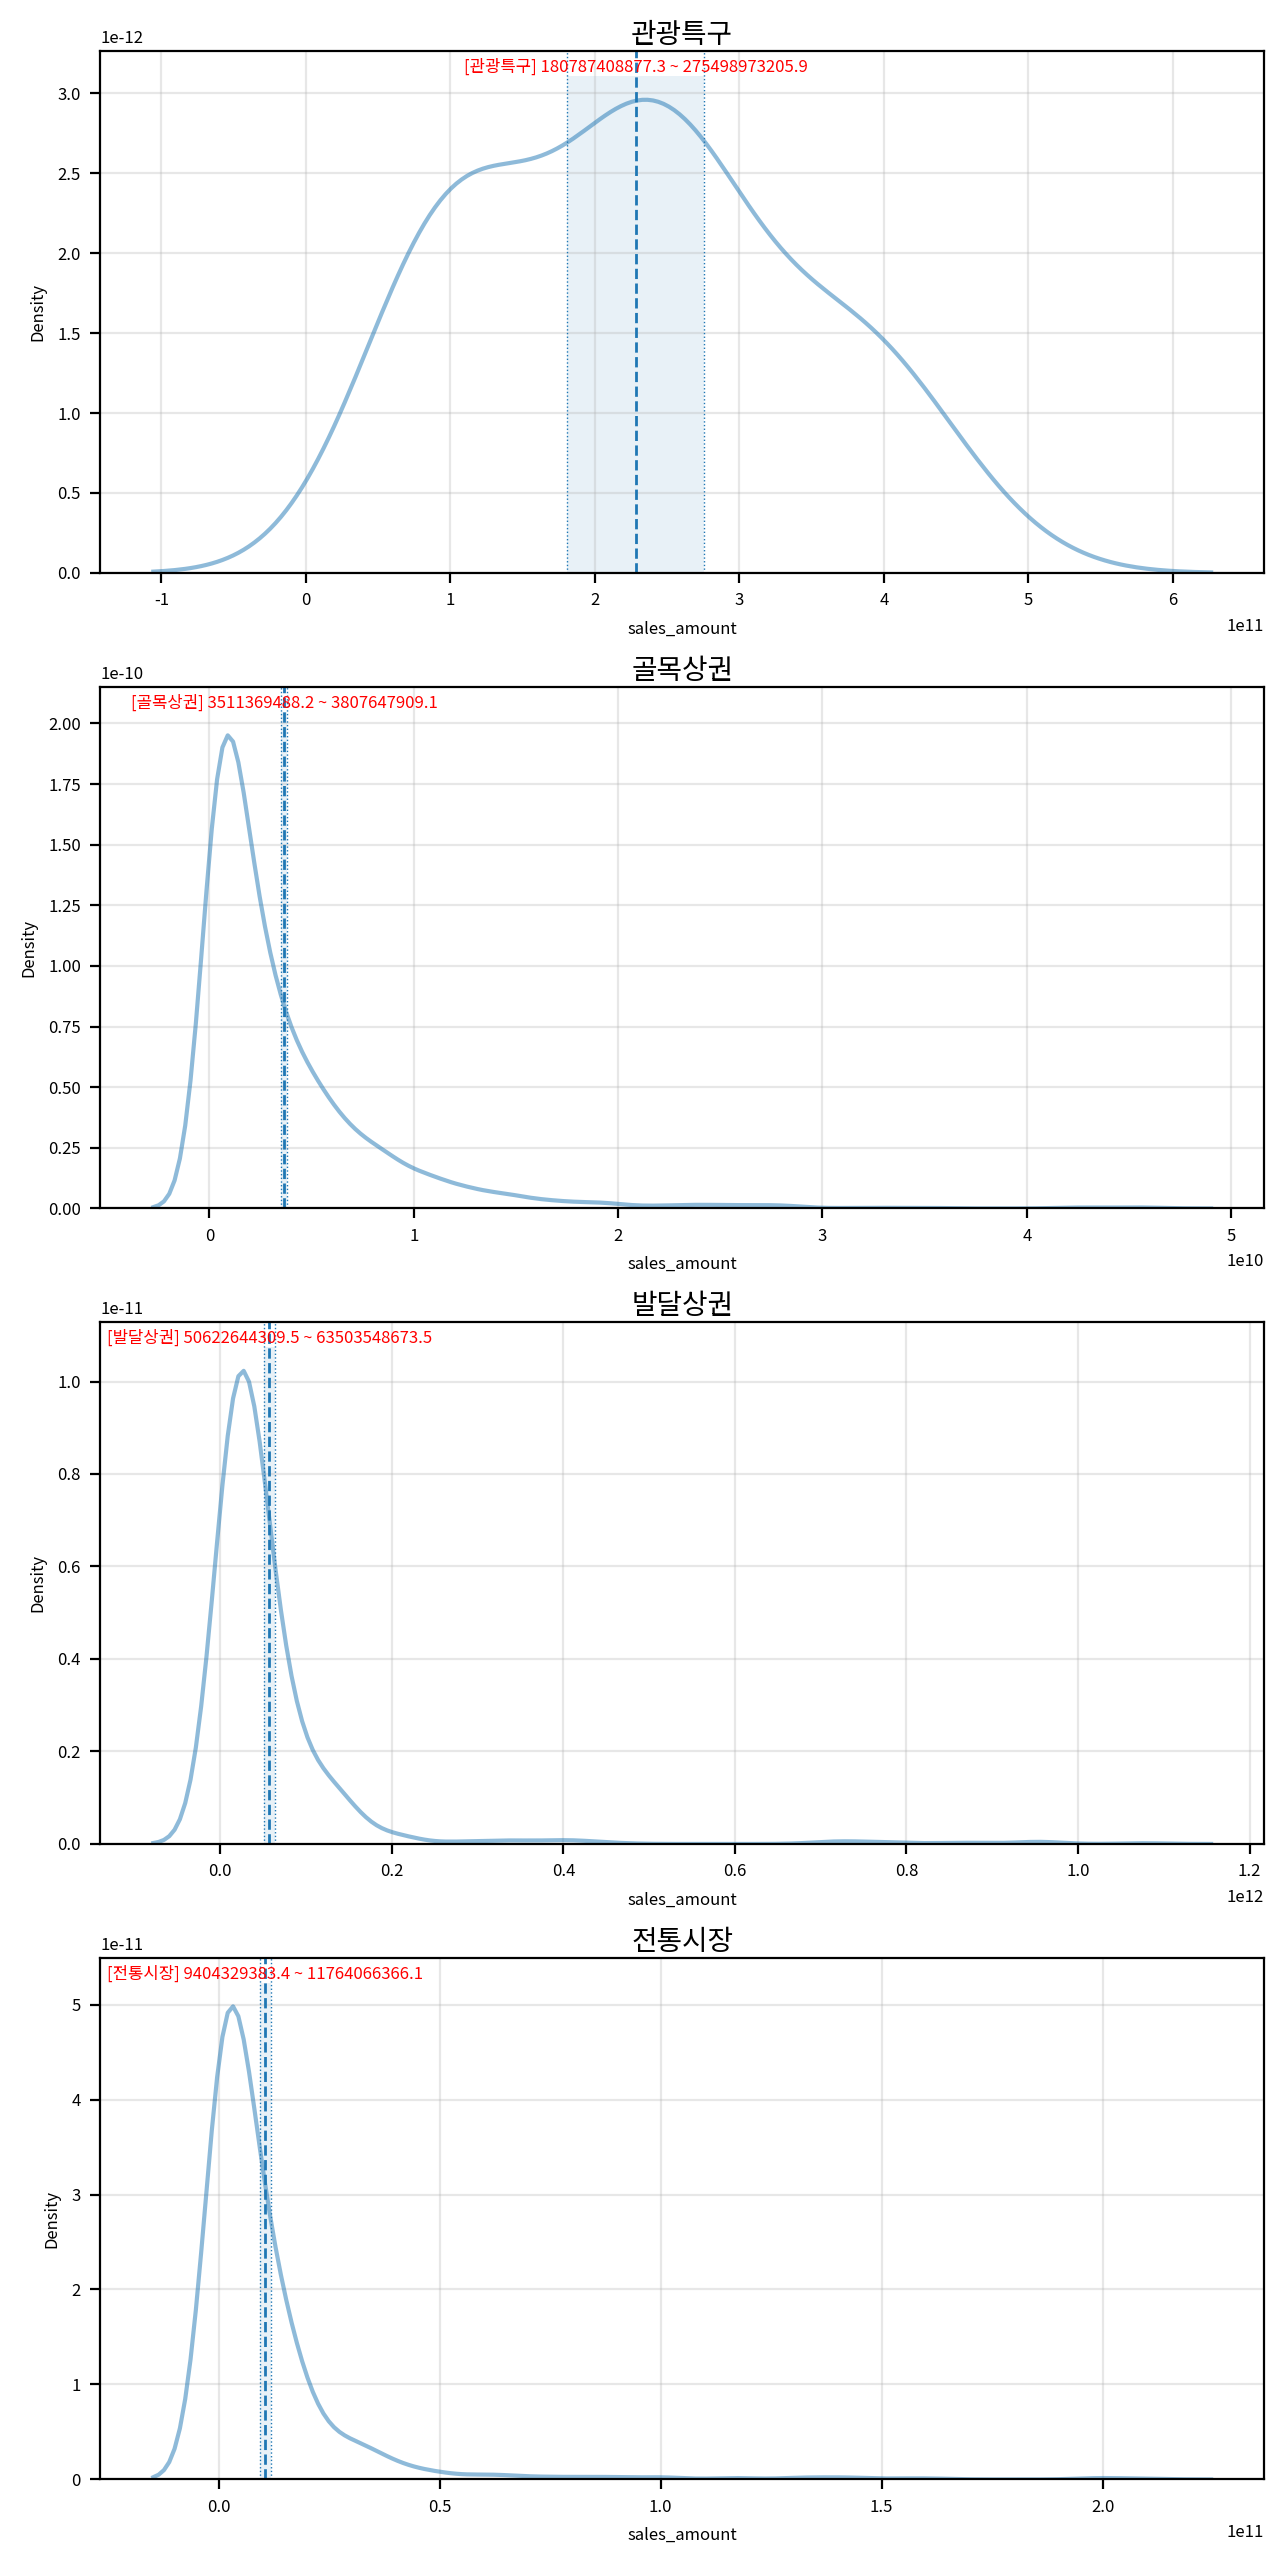

In [38]:
# 확인할 데이터 필드 (수치형):
field = 'sales_amount'

# 집단 구분용 필드 (범주형, hue):
hue_field = 'type'

# 요일 종류: 
hue_values = origin[hue_field].unique()
hue_count = len(hue_values)

# 1) 그래프 초기화 (초기설정, 캔버스(fig)랑 도화지(ax) 준비하기)
width_px = 1280             # 그래프 가로 크기
height_px = 640 * 4         # 그래프 세로 크기
rows = 4                    # 그래프 행 수
cols = 1                    # 그래프 열 수
figsize = (width_px / my_dpi, height_px / my_dpi)
fig, ax = plt.subplots(rows, cols, figsize = figsize, dpi = my_dpi)

for i, v in enumerate(hue_values):
    temp = origin[origin[hue_field] == v]
    #display(temp)

    # 2) KDE plot 그리기:
    sb.kdeplot(data=temp, x=field, fill=False, ax = ax[i], alpha=0.5)
    ax[i].grid(True, alpha=0.3)
    ax[i].set_title(v, fontsize=10, pad=3)

    # 신뢰구간용 기본변수:
    max = temp[field].max()                        # 최대값
    dof = len(temp[field]) - 1                     # 자유도
    clevel = 0.95                                  # 신뢰수준
    sp_mean = temp[field].mean()                   # 표본평균
    sp_std = temp[field].std(ddof=1) # default: ddof=1   # 표본표준편차
    sp_std_error = sp_std / sqrt(len(temp[field])) # 표본표준오차

    cmin, cmax = t.interval(clevel, dof, loc = sp_mean, scale = sp_std_error)

    ax[i].axvline(cmin, linestyle=":", linewidth=0.5) # cmin 경계선
    ax[i].axvline(cmax, linestyle=":", linewidth=0.5) # cmax 경계선

    # 신뢰구간 y값, 평균표시:
    ymin, ymax = ax[i].get_ylim()
    ax[i].fill_between([cmin, cmax], 0, ymax, alpha=0.1)
    ax[i].axvline(sp_mean, linestyle='--', linewidth=1)

    # 텍스트 그리기 (statAnnotator 기능):
    ax[i].text(x = cmin + (cmax-cmin)/2,
            y=ymax,
            s="[%s] %0.1f ~ %0.1f" % (v, cmin, cmax),
            horizontalalignment = "center",
            verticalalignment = "bottom",
            fontdict = {"size": 6, "color": "red"})

# 4) 출력
plt.tight_layout()           # 여백 제거
plt.show()                   # 그래프 화면 출력
plt.close()                  # 그래프 작업 종료

### 3. 정규성, 등분산성 가설 검정하기:

In [39]:
# hue 별 그룹 생성:
groups = [(name, grp['sales_amount']) for name, grp in origin.groupby('type')]
# ↑: pivot table (리스트, 2차월 배열 같은) 만든거임 
    # grping 된 data들
    # ex) [(금, [a, b, c, ..]), (토, [m,n,o,..]), (일, [..])]

report = []
normal_dist = True

for name, series in groups:
    stat, p = normaltest(series)
    ok = p > 0.05
    report.append({
        "fields": name,
        "statistic": stat,
        "p-value": p,
        "result": ok
    })
    normal_dist = normal_dist and ok

# 등분산성 검정법 선택:
    # 정규성 충족할 때 등분산성 검정방법:
if normal_dist:
    test_name = "Bartlett"
    stat, p = bartlett(*[s.values for _, s in groups]) # 모든 컬럼의 데이터 한번에
# 정규성 충족 못할 때 등분산성 검정법:
else:
    test_name = "Levene's"
    stat, p = levene(*[s.values for _, s in groups], 
                        center='median')
    # : 정규성 충족 못할 땐 '기본값인 평균'으로 계산하면 안됨

equal_var = p > 0.05

report.append({
    "fields": test_name,
    "statistic": stat,
    "p-value": p,
    "result": equal_var
})

report_df = DataFrame(report).set_index('fields')
report_df

,statistic,p-value,result
fields,,,
골목상권,2949.769498,0.000000e+00,False
관광특구,2.023450,3.635912e-01,True
발달상권,1174.363632,9.776365e-256,False
전통시장,1194.779826,3.604601e-260,False
Levene's,268.725277,5.300718e-164,False


### 4. 집단 간 평균 비교하기:

In [40]:
# 분석할 데이터만 추출:
anova_df = origin[['sales_amount', 'type']].copy()
#anova_df

# pingouin 패키지 사용:
if equal_var: # : 만약 등분산성 충족하면
    pg_anova = anova(data=anova_df, dv='sales_amount', between='type')
else: # : 만약 등분산성 충족 못하면
    pg_anova = welch_anova(data=anova_df, dv='sales_amount', between='type')
display(pg_anova)

# 결과 확인:
f_val = pg_anova['F'].iloc[0]
p_val = pg_anova['p-unc'].iloc[0]
"statistic: {0:.3f}, p-value: {1:.3f}, {2}가설 채택".format(f_val, p_val, "대립" if p_val<=0.05 else "귀무")

,Source,ddof1,ddof2,F,p-unc,np2
0,type,3,110.238825,161.432719,3.495920e-40,0.228001


'statistic: 161.433, p-value: 0.000, 대립가설 채택'

In [41]:
#결론: hue 그룹 간 평균값 끼리는 유의미한 차이 있다
# 얼마나? -> 사후검정 ㄱㄱ
if equal_var:
    print("=== Tukey HSD ===")
    hoc_df = pairwise_tukey(data=anova_df, dv='sales_amount', between='type')
else:
    print("=== Games-Howell ===")
    hoc_df = pairwise_gameshowell(data=anova_df, dv='sales_amount', between='type')

hoc_df

=== Games-Howell ===


,A,B,mean(A),mean(B),diff,se,T,df,pval,hedges
0,골목상권,관광특구,3.659509e+09,2.281432e+11,-2.244837e+11,2.289216e+10,-9.806138,23.000501,6.410146e-09,-23.206979
1,골목상권,발달상권,3.659509e+09,5.706310e+10,-5.340359e+10,3.282878e+09,-16.267309,996.054989,7.271961e-14,-1.160433
2,골목상권,전통시장,3.659509e+09,1.058420e+10,-6.924689e+09,6.060559e+08,-11.425826,1143.188337,0.000000e+00,-0.679464
3,관광특구,발달상권,2.281432e+11,5.706310e+10,1.710801e+11,2.312611e+10,7.397704,23.954998,7.128281e-07,1.647276
4,관광특구,전통시장,2.281432e+11,1.058420e+10,2.175590e+11,2.289993e+10,9.500421,23.031751,1.140238e-08,8.536768
5,발달상권,전통시장,5.706310e+10,1.058420e+10,4.647890e+10,3.336641e+09,13.929848,1061.849622,3.926859e-13,0.638976


### **인사이트:**

===========<강사님이 쓴거:>==========

**1. 분산분석(ANOVA) 결과:**

| **요인** | **F** | **p-value** | **해석** |
| ---- | ---- | ---- | ---- |
| 상권유형(type) | **161.433** | **p<0.0001** | 상권 유형 간 평균 매출액은 매우 강한 차이가 있음 |

- p-value가 0에 가까움 -> **귀무가설 기각, 대립가설 채택**
- 효과크기 **ηp² = 0.228 -> 중간이상~큰 효과,** 상권 유형은 매출액에 매우 강한 영향을 끼침

**2. 집단 별 평균(sales_amount):**

| 집단 | 평균 |
| ---- | --- |
| **골목상권** | $3.66 \times 10^9$ |
| **관광특구** | $2.28 \times 10^11$ |
| **발달상권** | $5.71 \times 10^10$ |
| **전통시장** | $1.06 \times 10^10$ |

- **관광특구가 압도적으로 가장 매출이 높고,** 골목상권이 가장 낮다.

**3. 집단 간 비교(사후검정)결과 해석(표):**

| 비교쌍 | 평균 차 **(diff)** | **p-value(Games-Howell)** | **통계적 유의성** | **효과크기 (hedges g)** | 해석 |
| ---- | ---- | ---- | ---- | ---- | ---- |
| **골목상권 vs 관광특구:** | $-2.245 \times 10^11$ | 6.4e-09 | 유의함 | -23.207 | 관광특구가 압도적으로 큼 |
| **골목상권 vs 발달상권:** | $-5.34 \times 10^10$ | 0.000 | 유의함 | -1.160 | 발달상권이 골목상권보다 매우 큼 |
| **골목상권 vs 전통시장:** | $-6.92 \times 10^9$ | 0.000 | 유의함 | -0.679 | 전통시장이 골목상권보다 큼 |
| **관광특구 vs 발달상권:** | $1.71 \times 10^11$ | 7.1e-07 | 유의함 | 1.647 | 관광특구가 발달상권보다 큼 |
| **관광특구 vs 전통시장:** | $2.18 \times 10^11$ | 1.1e-08 | 유의함 | 8.537 | 관광특구가 전통시장보다 압도적으로 큼 |
| **발달상권 vs 전통시장:** | $4.65 \times 10^10$ | 0.000 | 유의함 | 0.639 | 발달상권이 전통시장보다 큼 |

**4. 객관적 사실 정리:**
- **ANOVA 결과,** 상권 유형에 따른 매출액의 평균이 **통계적으로 매우 크게 차이남.**
- **관광특구의 평균 매출액은 모든 상권을 압도적으로 상회함.**
- **골목상권은 네 상권 중 가장 낮은 매출규모**를 보임.
- **모든 비교쌍에서 통계적 유의성이 확인 됨:** 상권 유형 간 매출액은 서로 확실히 다름.
- 특히 **관광특구는 발달상권, 전통시장, 골목상권 모두와 차이가 매우 크며,** 효과크기(hedges g)가 **절댓값 8~23 수준**으로 **극도로 큰 효과**가 나타남.
- 이는 **관광특구의 매출 구조가 다른 상권과 전혀 다른 스케일로 운영되고 있읆을 의미**함.
- 발달상권과 전통시장도 **유의하게 다르며,** 발달상권 > 전통시장 > 골목상권 순으로 매출 규모가 커짐.

**5. 결론 요약**
>**2023년 서울시 상권 유형 별 평균 매출액은 서로 유의미하게 다른 패턴을 보이며, 특히 관광특구는 다른 모든 상권 대비 압도적으로 높은 매출 규모를 보여준다.**
> **전체 순위는 관광특구 > 발달상권 > 전통시장 > 골목상권이다.**

=========<아래는 내가 쓴거:>=========
> 1. 유의수준 0.05 기준에서 상권 종류 별로 2023년 한 해 동안의 평균 매출액을 비교해 본 결과, 
>   - 관광특구만 평균매출액 데이터에서 정규성을 만족하였고 
>   - 이외의 골목상권, 발달상권, 전통시장 세 종류의 상권에서는 정규성을 만족 하지 못하였고 
>   - 네 그룹 간 등분산성도 충족 못함이 보였다.
> 2. 